In [2]:
import sys
import polars as pl
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

# adding Folder_2 to the system path
sys.path.insert(0, '../Python')

from helper_add_ep_wp import add_ep_variables
from helper_add_hudl_mutations import make_hudl_mutations, prepare_ep_data
from helper_add_model_mutations import make_ep_model_mutations

In [6]:
df = pl.read_csv("../data_raw.csv",separator=";",infer_schema_length=0)
df = make_hudl_mutations(df)
df = df.with_columns(pl.col(pl.UInt32).cast(pl.Int32).name.keep())

df_wc = (pl.read_csv("../data/wc24_pbp.csv",separator=",",
                     schema_overrides = {"posteam": pl.String,"posteam_after": pl.String,"defteam": pl.String,"defteam_after": pl.String,
                                         "home_team": pl.String,"home_team_after": pl.String,"away_team": pl.String,"away_team_after": pl.String,
                                         "scoring_play_team": pl.String,"penalty": pl.Int32})
         .with_columns(pl.col(pl.Int64).cast(pl.Int32).name.keep())
         )

df = pl.concat([df, df_wc],how="diagonal")
df2 = prepare_ep_data(df)

In [7]:
# Spaltenauswahl
selected_columns = [
    "label",
    # "half_seconds_remaining",
    "yardline_50",
    # "yardline_50_simple",
    "yards_to_go",
    # "yards_to_go_simple",
    "down0", "down1", "down2", "down3", "down4",
    "Total_W_Scaled",
]

features = [
    # "half_seconds_remaining",
    "yardline_50",
    # "yardline_50_simple",
    "yards_to_go",
    # "yards_to_go_simple",
    "down0", "down1", "down2", "down3", "down4",
    ]

In [11]:
model_data = df2.filter(pl.col("game_id") != 37)

model_data = make_ep_model_mutations(model_data, selected_columns)

In [12]:
for x in model_data.columns: # df.columns returns a list of columns
  print("{} : {}".format(x, model_data[x].null_count()))

label : 190
yardline_50 : 0
yards_to_go : 0
down0 : 0
down1 : 0
down2 : 0
down3 : 0
down4 : 0
Total_W_Scaled : 0


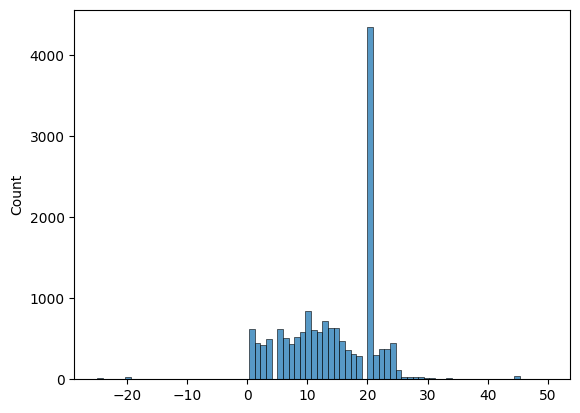

In [13]:
k = model_data.drop_nulls()
# k = model_data.drop_nulls().groupby(pl.col(["down","yards_to_go_simple"])).count()
sns.histplot(k.select("yards_to_go").to_series())# You need to use .select() to obtain a series
plt.show()

In [14]:
model_data = model_data.drop_nulls()

X= model_data.select(features)
y = model_data.select("label")
weight_X, weight_y = train_test_split(model_data.select("Total_W_Scaled"),test_size = 0.2, random_state = 42)
train_X, test_X, train_y, test_y = train_test_split(X, y,test_size = 0.2, random_state = 42)

In [17]:
model = xgb.XGBRegressor(
    booster = "gbtree",
    objective = "multi:softprob",
    eval_metric = "mlogloss",
    num_class = 5,
    eta = 0.025,
    gamma = 1,
    subsample = 0.8,
    colsample_bytree = 0.8,
    max_depth = 5,
    min_child_weight = 1
)

model.fit(train_X.to_numpy(), train_y.select("label").to_numpy(), sample_weight = weight_X)
model.get_booster().feature_names = features

<Figure size 640x480 with 0 Axes>

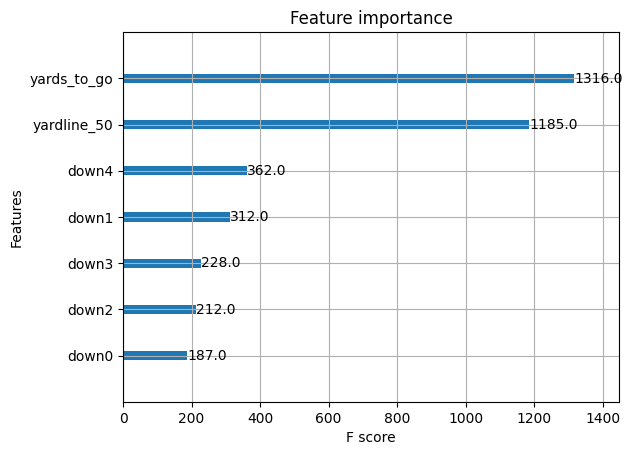

In [18]:
fig=plt.gcf()
xgb.plot_importance(model)
# plt.title("Feature Importance for "+asset_name)
plt.show()

In [19]:
space={
    'max_depth': hp.quniform("max_depth", 3, 18, 1),
    # "max_depth": 3,
    'gamma': hp.uniform ('gamma', 0,9),
    # "gamma": 0,
    'reg_alpha': hp.uniform('reg_alpha', 0,0.05),
    # 'reg_alpha': 140.0,
    'reg_lambda': hp.uniform('reg_lambda', 0,1),
    # 'reg_lambda': 0.2,
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5,1),
    # "colsample_bytree": 0.8,
    'min_child_weight': hp.quniform('min_child_weight', 0, 10, 1),
    # "min_child_weight": 3,
    'n_estimators': hp.quniform('n_estimators', 1, 1000, 50),
    "eta": hp.uniform("eta", 0.01, 0.1),
    'seed': 0
    }

In [24]:
from sklearn.metrics import log_loss

def model_objective(space):
    clf=xgb.XGBClassifier(
        n_estimators = int(space['n_estimators']), 
        eta = space["eta"],
        max_depth = int(space['max_depth']), 
        gamma = space['gamma'],
        reg_alpha = int(space['reg_alpha']),
        min_child_weight=int(space['min_child_weight']),
        colsample_bytree=int(space['colsample_bytree']),
        eval_metric="mlogloss",
        early_stopping_rounds=10)
    
    evaluation = [( train_X, train_y), ( test_X, test_y)]
    
    clf.fit(train_X, train_y,
            eval_set=evaluation, 
            verbose=False)
    

    # Vorhersagen machen
    pred_proba = clf.predict_proba(test_X)
    
    # Log Loss berechnen
    loss = log_loss(test_y, pred_proba)

    print("Log Loss:", loss)
    
    return {'loss': loss, 'status': STATUS_OK}

In [25]:
import warnings

# Unterdrücken von UserWarnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

trials = Trials()

best_hyperparams = fmin(fn = model_objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

# Zurücksetzen der Warnungseinstellungen, wenn nötig
warnings.resetwarnings()

Log Loss:                                              
0.9847086676664498                                     
Log Loss:                                                                        
0.9801244233017049                                                               
Log Loss:                                                                        
0.9823586220191199                                                               
Log Loss:                                                                        
0.9883643417680871                                                               
Log Loss:                                                                        
0.9828582247032168                                                               
Log Loss:                                                                        
0.9835818038639111                                                               
Log Loss:                                                           

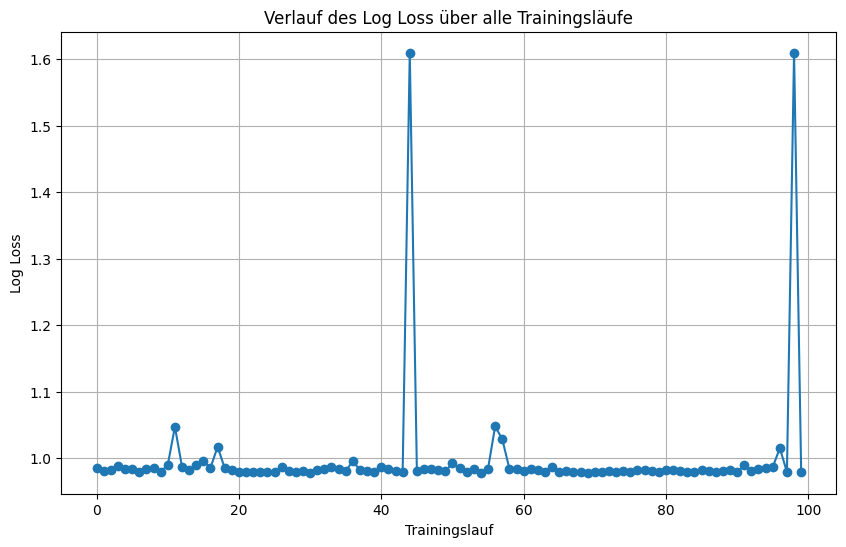

In [26]:
import matplotlib.pyplot as plt

# Liste, um den Log Loss für jeden Trainingslauf zu speichern
log_losses = [trial['result']['loss'] for trial in trials.trials]

# Plot des Log Loss über alle Trainingsläufe
plt.figure(figsize=(10, 6))
plt.plot(log_losses, marker='o', linestyle='-')
plt.xlabel('Trainingslauf')
plt.ylabel('Log Loss')
plt.title('Verlauf des Log Loss über alle Trainingsläufe')
plt.grid(True)
plt.show()

In [27]:
best_hyperparams

{'colsample_bytree': np.float64(0.5879487610413734),
 'eta': np.float64(0.08528828200347069),
 'gamma': np.float64(0.04370420853345891),
 'max_depth': np.float64(12.0),
 'min_child_weight': np.float64(1.0),
 'n_estimators': np.float64(400.0),
 'reg_alpha': np.float64(0.044042646059168536),
 'reg_lambda': np.float64(0.6711875070888024)}

In [28]:
model_tune = xgb.XGBRegressor(
    booster = "gbtree",
    objective = "multi:softprob",
    eval_metric = "mlogloss",
    n_estimators = int(best_hyperparams["n_estimators"]),
    num_class = 5,
    eta = best_hyperparams["eta"],
    gamma = best_hyperparams["gamma"],
    colsample_bytree = best_hyperparams["colsample_bytree"],
    max_depth = int(best_hyperparams["max_depth"]),
    min_child_weight = int(best_hyperparams["min_child_weight"]),
    reg_alpha = best_hyperparams["reg_alpha"],
    reg_lambda = best_hyperparams["reg_lambda"]
)

model_tune.fit(model_data.select(features).to_numpy(), model_data.select("label").to_numpy(), sample_weight = model_data.select("Total_W_Scaled").to_numpy())
model_tune.get_booster().feature_names = features

<Figure size 640x480 with 0 Axes>

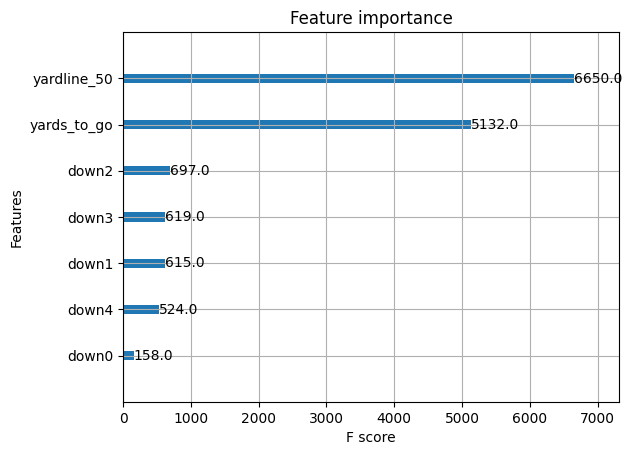

In [29]:
fig=plt.gcf()
xgb.plot_importance(model_tune)
# plt.title("Feature Importance for "+asset_name)
plt.show()

In [30]:
from sklearn.metrics import log_loss

# Calculate predictions
y_pred = model_tune.predict(test_X.to_numpy())

multiclass_log_loss = log_loss(test_y, y_pred)
print("Multiclass Log Loss:", multiclass_log_loss)


Multiclass Log Loss: 0.954911220803827


In [31]:
import pickle
file_name = "ep_model.pkl"
# save
pickle.dump(model_tune, open(file_name, "wb"))

C:\Users\Templer\AppData\Local\Temp\ipykernel_94944\1088323240.py:4: ResourceWarning: unclosed file <_io.BufferedWriter name='ep_model.pkl'>
  pickle.dump(model_tune, open(file_name, "wb"))
